<a href="https://colab.research.google.com/github/Juneyy/COMP-SCI-190-Final-Project/blob/main/COMP_SCI_190_Final_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/10QZKKwj0WY5ChcDFj4S_XdnUTWlinfNG#scrollTo=V9k2Gg7IYul0)


The final class project is to develop a model to detect pulmonary infection (pneumonia) on chest radiographs using any of the approaches and tools you have learned this quarter. The goal is both to create a high-performing algorithm for the target task, as well as to analyze performance across several different architecture permutations. At minimum, three different network designs of your choice will be tested (you are welcome to include more if you've tested others). As each model is built and trained, ensure to serialize the final model `*.hdf5` file before moving to the next iteration.

This assignment is part of the class **Introduction to Deep Learning for Medical Imaging** at University of California Irvine (CS190); more information can be found: https://github.com/peterchang77/dl_tutor/tree/master/cs190.

### Submission

Once complete, the following items must be submitted:

* final `*.ipynb` notebook
* final trained `*.hdf5` model files for **all** models (each independently saved)
* final compiled `*.csv` file with performance statistics across the different architectures
* final write-up with methods and results of experiments

# Google Colab

The following lines of code will configure your Google Colab environment for this assignment.

### Enable GPU runtime

Use the following instructions to switch the default Colab instance into a GPU-enabled runtime:

```
Runtime > Change runtime type > Hardware accelerator > GPU
```

### Mount Google Drive

The Google Colab environment is transient and will reset after any prolonged break in activity. To retain important and/or large files between sessions, use the following lines of code to mount your personal Google drive to this Colab instance:

In [ ]:
try:
    # --- Mount gdrive to /content/drive/My Drive/
    from google.colab import drive
    drive.mount('/content/drive')
    
except: pass

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Throughout this assignment we will use the following global `MOUNT_ROOT` variable to reference a location to store long-term data. If you are using a local Jupyter server and/or wish to store your data elsewhere, please update this variable now.

In [ ]:
# --- Set data directory
MOUNT_ROOT = '/content/drive/My Drive'

### Select Tensorflow library version

This assignment will use the (new) Tensorflow 2.1 library. Use the following line of code to select this updated version:

In [ ]:
# --- Select Tensorflow 2.0 (only in Google Colab)
% tensorflow_version 2.x
% pip install tensorflow-gpu==2.1

     |████████████████████████████████| 421.8MB 30kB/s 
     |████████████████████████████████| 3.9MB 51.5MB/s 
     |████████████████████████████████| 450kB 53.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=4128aeeeeb42918e79cf4403ec929305c9bbfd2859237248079ef4160838f96a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:

# Environment

### Jarvis library

In this notebook we will Jarvis, a custom Python package to facilitate data science and deep learning for healthcare. Among other things, this library will be used for low-level data management, stratification and visualization of high-dimensional medical data.

In [ ]:
# --- Install jarvis (only in Google Colab or local runtime)
% pip install jarvis-md

     |████████████████████████████████| 71kB 227kB/s 
     |████████████████████████████████| 276kB 13.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=f1beb30b72219b762766e7cb0b321fd546ab3007138543c355c285de715531a1
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Imports

Use the following lines to import any additional needed libraries (note that depending on architecture choices, various additional modules will need to be specified here):

In [ ]:
import numpy as np, pandas as pd
from tensorflow import losses, optimizers
from tensorflow.keras import Input, Model, models, layers, metrics, callbacks, regularizers 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from jarvis.train import datasets, custom
from jarvis.train.client import Client
from jarvis.utils.general import overload, tools as jtools
from jarvis.utils.display import imshow
import os
import matplotlib.pyplot as plt

# Data

The data used in this tutorial will consist of (frontal projection) chest radiographs from the RSNA / Kaggle pneumonia challenge (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge). The chest radiograph is the standard screening exam of choice to identify and trend changes in lung disease including infection (pneumonia). 

### Download

The custom `datasets.download(...)` method can be used to download a local copy of the dataset. By default the dataset will be archived at `/data/raw/xr_pna`; as needed an alternate location may be specified using `datasets.download(name=..., path=...)`. 

In [ ]:
# --- Download dataset
datasets.download(name='xr/pna-crp')

[ 2020-06-10 03:49:22 ] [====================] 100.000% : Extracting archive (0116021 / 0116021) 

{'code': '/data/raw/xr_pna', 'data': '/data/raw/xr_pna'}

### Python generators

Once the dataset is downloaded locally, Python generators to iterate through the dataset can be easily prepared using the `datasets.prepare(...)` method.

# Can use another generator to make another data augmentation generator

### Model inputs

For every input in `xs`, a corresponding `Input(...)` variable can be created and returned in a `inputs` dictionary for ease of model development:

In [ ]:
# --- Prepare generators
gen_train, gen_valid, client = datasets.prepare(name='xr/pna-crp', keyword='crp')

In [ ]:
@overload(Client)

#very imporantant for today's session

def preprocess(self, arrays, **kwargs):
    """
    Method to create a custom msk array for class weights and/or masks
    
    """
    # --- Create msk
    msk = np.zeros(arrays['xs']['dat'].shape)
    lng = arrays['xs']['msk'] > 0
    pna_seg = arrays['ys']['pna-seg'] > 0
    msk[lng] = 1
    msk[pna_seg] = 1
    
    arrays['xs']['msk'] = msk
    
    return arrays

In [ ]:
yml = '{}/data/ymls/client-crp.yml'.format(jtools.get_paths('xr/pna')['code'])

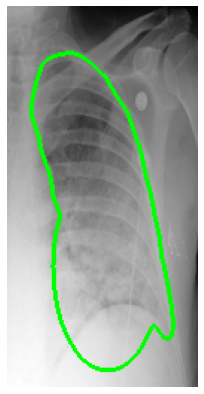

In [ ]:
# --- Manually create Client
client = Client(yml)

# --- Manually create generators
gen_train, gen_valid = client.create_generators()
inputs = client.get_inputs(Input)

# --- Show
xs, ys = next(gen_train)
imshow(xs['dat'][0], xs['msk'][0], radius = 3)

In [ ]:
# # --- Create model inputs
# inputs = client.get_inputs(Input)

# print(inputs.keys())
# print(inputs['dat'].shape)
# print(inputs['msk'].shape)

# xs, ys = next(gen_train)
# print(xs.keys())
# print(ys.keys())

# Training

The goal of this project is to perform **global classification** for each image. In other words, regardless of algorithm choice, the final objective is to determine the absence or presence of pneumonia for each sample. This does **not** mean that you are required to use classification networks only; in fact it very well may be the case that a localization algorithm will overall perform better on this task.

The task is designed to be open-ended on purpose. The only requirements are to:

* test at minimum three different network architectures
* one algorithm must use (at least) a classification type loss function
* one algorithm must use (at least) a segmentation type loss function

Note that the qualifier *at least* indicates that if you choose, you can use both classification and segmentation losses simultaneously for one algorithm to satisfy both requirements (this would allow you to test only non-classification / non-segmentation architectures for all remaining models if you choose).

Model 1

In [ ]:
kwargs = {
    'kernel_size': (1,3,3),
    'padding': 'same'}
kwargs1 = {
    'padding': 'same'}



conv = lambda x, filters, strides, kernel_size, kernel_regularizer: layers.Conv3D(filters = filters, kernel_size = kernel_size, strides = strides, kernel_regularizer = kernel_regularizer, **kwargs1)(x)
norm = lambda x : layers.BatchNormalization()(x)
leakyrelu = lambda x: layers.LeakyReLU()(x)
zoom = lambda x : layers.UpSampling3D(size=(1, 2, 2))(x)

proj = lambda filters, x : layers.Conv3D(filters=filters, strides= (1,1,1), kernel_size=(1, 1, 1), padding='same')(x)

pool = lambda x : layers.MaxPool3D(pool_size=(1,3,3), strides=1, padding='same')(x)

pool1 = lambda x : layers.MaxPool3D(pool_size=(1,3,3), strides=(1,2,2), padding='same')(x)

dense = lambda x, units, kernel_regularizer: layers.Dense(units = units, kernel_regularizer = kernel_regularizer)(x)
transpose = lambda x, filters, strides, kernel_regularizer: layers.Conv3DTranspose(filters = filters, strides = strides, kernel_regularizer = kernel_regularizer, **kwargs)(x)

conv1_1 = lambda filters, x, strides, : leakyrelu(norm(conv(x, filters = filters, kernel_size = (1,1,1), strides = strides, kernel_regularizer = None)))
conv2_1 = lambda filters, x, : leakyrelu(norm(conv(x, filters = filters, kernel_size = (1,3,3), strides = (1,2,2), kernel_regularizer = None)))

conv3_1 = lambda filters, x, strides : leakyrelu(norm(conv(x, filters, kernel_size = (1,3,3), strides = strides, kernel_regularizer = None)))
conv5_1 = lambda filters, x, strides : leakyrelu(norm(conv(x, filters, kernel_size = (1,5,5), strides = strides, kernel_regularizer = None)))

mpool_1 = lambda x : leakyrelu(norm(pool(x)))
mpool1_1 = lambda x : leakyrelu(norm(pool1(x)))
upsample_2 = lambda x: leakyrelu(norm(zoom(x)))

In [ ]:
def inception(filters, input):
  p1 = conv1_1(int(filters/4), input, (1,1,1))
  p2 = conv3_1(int(filters/4), input, (1,1,1))
  p3 = conv3_1(int(filters/4), conv3_1(int(filters/4), input, (1,1,1)), (1,1,1))
  p4 = proj(int(filters/4), mpool_1(input))
  return layers.Concatenate()([p1, p2, p3, p4])

def inception2(filters, input):
  p1 = conv1_1(int(filters/4), input, (1,2,2))
  p2 = conv3_1(int(filters/4), input, (1,2,2))
  p3 = conv3_1(int(filters/4), conv3_1(int(filters/4), input, (1,1,1)), (1,2,2))
  p4 = proj(int(filters/4), mpool1_1(input))
  return layers.Concatenate()([p1, p2, p3, p4])



In [ ]:
a_1 = 1

c1_1 = inception(int(8*a_1), inputs['dat'])
c2_1 = inception(int(16*a_1), inception2(int(16*a_1),c1_1))
c2_1_1 = inception(int(16*a_1), c2_1)
c3_1 = inception(int(32*a_1), inception2(int(32*a_1),c2_1_1))
c3_1_1 = inception(int(32*a_1), c3_1)
c4_1 = inception(int(48*a_1), inception2(int(48*a_1),c3_1_1))
c4_1_1 = inception(int(48*a_1), c4_1)
c5_1 = inception(int(64*a_1), inception(int(64*a_1),c4_1_1))
c5_1_1 = inception(int(64*a_1), c5_1)
c6_1 = inception(int(64*a_1), inception(int(64*a_1),c5_1_1))
c6_1_1 = inception(int(64*a_1), c6_1)
c7_1 = inception(int(32*a_1), inception(int(32*a_1),c6_1_1)) #bottleneck
c8_1_1 = inception(int(16*a_1), c7_1)
c9_1_1 = inception(int(32*a_1), c8_1_1)
c10_1_1 = inception(int(48*a_1), c9_1_1)
c11_1_1 = inception(int(48*a_1), inception(int(48*a_1),c10_1_1))
c12_1_1 = inception(int(48*a_1), c11_1_1)


r1_1 = layers.Reshape((-1,1,1,32*16*int(48*a_1)))(c12_1_1)
r2_1 = leakyrelu(norm(layers.Conv3D(int(24*a_1), kernel_size = (1,1,1))(r1_1)))
r3_1 = leakyrelu(norm(layers.Conv3D(int(8*a_1), kernel_size = (1,1,1))(r2_1)))



logits_1 = {}

logits_1['pna-cls'] = layers.Conv3D(2, name = 'pna-cls', kernel_size = (1,1,1))(r3_1)


model1 = Model(inputs = inputs, outputs = logits_1)

model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dat (InputLayer)                [(None, 1, 256, 128, 0                                            
__________________________________________________________________________________________________
conv3d_128 (Conv3D)             (None, 1, 256, 128,  20          dat[0][0]                        
__________________________________________________________________________________________________
batch_normalization_134 (BatchN (None, 1, 256, 128,  8           conv3d_128[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_134 (LeakyReLU)     (None, 1, 256, 128,  0           batch_normalization_134[0][0]    
____________________________________________________________________________________________

In [ ]:
model1.compile(
    optimizer=optimizers.Adam(learning_rate=2e-4),
    loss={
        'pna-cls': losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={
        'pna-cls': metrics.SparseCategoricalAccuracy()
        },
    experimental_run_tf_function=False)

In [ ]:
model1_check = '{}/models/final/model_checkpoint1.h5'.format(MOUNT_ROOT)
os.makedirs(os.path.dirname(model1_check), exist_ok=True)
check_point_1 = ModelCheckpoint(model1_check,monitor='val_sparse_categorical_accuracy',verbose=True, save_best_only=True, save_weights_only=True, mode="max", save_freq="epoch")
reduce_lr_1 = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', factor=0.70, patience=2, mode = "max", verbose = 1)

In [ ]:
history_1 = model1.fit(
    x = gen_train,
    steps_per_epoch = 75,
    epochs = 100,
    validation_data = gen_valid,
    validation_steps = 75,
    validation_freq = 1,
    callbacks = [check_point_1, reduce_lr_1],
    use_multiprocessing=True,
    verbose = 2)

Epoch 1/100
Epoch 1/100
75/75 - 16s - loss: 0.9556 - sparse_categorical_accuracy: 0.4056

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.40556, saving model to /content/drive/My Drive/models/final/model_checkpoint1.h5
75/75 - 96s - loss: 0.6348 - sparse_categorical_accuracy: 0.6767 - val_loss: 0.9556 - val_sparse_categorical_accuracy: 0.4056
Epoch 2/100
Epoch 1/100
75/75 - 9s - loss: 0.7388 - sparse_categorical_accuracy: 0.4067

Epoch 00002: val_sparse_categorical_accuracy improved from 0.40556 to 0.40667, saving model to /content/drive/My Drive/models/final/model_checkpoint1.h5
75/75 - 36s - loss: 0.5376 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7388 - val_sparse_categorical_accuracy: 0.4067
Epoch 3/100
Epoch 1/100
75/75 - 9s - loss: 0.7959 - sparse_categorical_accuracy: 0.4467

Epoch 00003: val_sparse_categorical_accuracy improved from 0.40667 to 0.44667, saving model to /content/drive/My Drive/models/final/model_checkpoint1.h5
75/75 - 36s - loss: 0.44

In [ ]:
model1_checkcurrent = '{}/models/final/model_checkpoint1_current.h5'.format(MOUNT_ROOT)
#model1.save_weights(model1_checkcurrent)
model1.load_weights(model1_checkcurrent)

In [ ]:
# --- Run model prediction for segmentation masks
test_train, test_valid = client.create_generators(test=True)

nnzs_1 = []
true_1 = []

for xs, ys in test_train:
    
    logs_1 = model1.predict(xs)
    pred_1 = np.argmax(logs_1[0], axis=-1)
    
    # --- Record number of pixels in mask
    nnzs_1.append(pred_1.squeeze())
    true_1.append(ys['pna-cls'].squeeze())
    
    # --- Break after 1000 exams
    if len(nnzs_1) == 1000:
        break

# --- Convert to arrays
nnzs_1 = np.array(nnzs_1)
true_1 = np.array(true_1)

df = pd.DataFrame(index=np.arange(nnzs_1.size))

df['nnzs_1'] = nnzs_1
df['nnzs_1'] = true_1




[ 2020-06-10 03:53:34 ] [>...................] 4.200% : Iterating | 001000      

In [ ]:
def calculate_stats1(true, pred):
    """
    Method to calculate binary classification stats
    
    """
    # --- Calculate true positives / true negatives
    tp = np.count_nonzero((true == 1) & (pred == 1))
    tn = np.count_nonzero((true == 0) & (pred == 0))
    fp = np.count_nonzero((true == 0) & (pred == 1))
    fn = np.count_nonzero((true == 1) & (pred == 0))

    # --- Stats
    acc = (tp + tn) / (tp + tn + fp + fn)
    sen = tp / (tp + fn)
    spe = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    
    return acc, sen, spe, ppv, npv

print(calculate_stats1(true_1, nnzs_1))

(0.883, 0.8738317757009346, 0.8898601398601399, 0.8558352402745996, 0.9040852575488455)


Model 2

In [ ]:
# --- Define stride-1, stride-2 blocks
conv1_2 = lambda filters, x, : leakyrelu(norm(conv(x, filters = filters, strides = (1,1,1), kernel_regularizer = None)))
conv2_2 = lambda filters, x, : leakyrelu(norm(conv(x, filters = filters, kernel_size = (1,3,3), strides = (1,2,2), kernel_regularizer = None)))
tran_2 = lambda filters, x : leakyrelu(norm(transpose(x, filters, strides = (1,2,2), kernel_regularizer = None)))

In [ ]:
dropout_rate_2 = 0.0

a_2 = 5

c1_2 = inception(int(8*a_2), inputs['dat'])
c2_2 = inception(int(16*a_2), conv2_2(int(16*a_2),c1_2))
c3_2 = inception(int(16*a_2), c2_2)
c4_2 = inception(int(32*a_2), conv2_2(int(32*a_2),c3_2))
c5_2 = inception(int(32*a_2), c4_2)
c6_2 = inception(int(64*a_2), conv2_2(int(64*a_2),c5_2))
c7_2 = inception(int(64*a_2), c6_2)
c8_2 = inception(int(64*a_2), conv2_2(int(64*a_2),c7_2))
c9_2 = inception(int(64*a_2), c8_2)
c10_2 = inception(int(64*a_2), conv2_2(int(64*a_2),c9_2))
c11_2 = inception(int(64*a_2), c10_2)
c12_2 = inception(int(64*a_2), conv2_2(int(64*a_2),c11_2))
c13_2 = inception(int(64*a_2), c12_2)



e1_2 = tran_2(int(64*a_2), c13_2) 
e2_2 = inception(int(64*a_2), e1_2)
e3_2 = tran_2(int(64*a_2), e2_2 + inception(int(64*a_2), c11_2)) 
e4_2 = inception(int(64*a_2), e3_2)
e5_2 = tran_2(int(64*a_2), e4_2 + inception(int(64*a_2), c9_2)) 
e6_2 = inception(int(64*a_2), e5_2)
e7_2 = tran_2(int(64*a_2), e6_2 + inception(int(64*a_2), c7_2))
e8_2 = inception(int(32*a_2), e7_2)
e9_2 = tran_2(int(32*a_2), e8_2 + inception(int(32*a_2), c5_2)) 
e10_2 = inception(int(16*a_2), e9_2)
e11_2 = tran_2(int(16*a_2), e10_2 + inception(int(16*a_2), c3_2)) 
e12_2 = inception(int(8*a_2), e11_2)



logits_2 = {}

logits_2['pna-seg'] = layers.Conv3D(filters = 2, name = 'pna-seg', **kwargs)(e12_2 + c1_2)


model2 = Model(inputs = inputs, outputs = logits_2)

model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dat (InputLayer)                [(None, 1, 256, 128, 0                                            
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 1, 256, 128,  100         dat[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 1, 256, 128,  40          conv3d_2[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_2 (LeakyReLU)       (None, 1, 256, 128,  0           batch_normalization_2[0][0]      
______________________________________________________________________________________________

In [ ]:
model2_check = '{}/models/final/model_checkpoint2.h5'.format(MOUNT_ROOT)
check_point_2 = ModelCheckpoint(model2_check,monitor='val_dsc_1',verbose=True, save_best_only=True, save_weights_only=True, mode="max", save_freq="epoch")
reduce_lr_2 = ReduceLROnPlateau(monitor='val_dsc_1', factor=0.80, patience=2, mode = "max", verbose = 1)

In [ ]:
model2.compile(
    optimizer=optimizers.Adam(learning_rate=2e-4),
    loss={
        'pna-seg': custom.sce(inputs['msk'])},
    metrics = {'pna-seg': custom.dsc(weights=inputs['msk'])},
    experimental_run_tf_function=False)

In [ ]:
history_2 = model2.fit(
    x = gen_train,
    steps_per_epoch = 75,
    epochs = 55,
    validation_data = gen_valid,
    validation_steps = 75,
    validation_freq = 1,
    callbacks = [check_point_2, reduce_lr_2])

Epoch 1/10
75/75 [==============================] - 125s 2s/step - loss: 0.0743 - dsc_1: 0.7187
Epoch 2/10
75/75 [==============================] - 124s 2s/step - loss: 0.0831 - dsc_1: 0.7448
Epoch 3/10
75/75 [==============================] - 124s 2s/step - loss: 0.0708 - dsc_1: 0.7196
Epoch 4/10
75/75 [==============================] - 124s 2s/step - loss: 0.0728 - dsc_1: 0.7496
Epoch 5/10
75/75 [==============================] - 123s 2s/step - loss: 0.0806 - dsc_1: 0.7154
Epoch 6/10
75/75 [==============================] - 124s 2s/step - loss: 0.0752 - dsc_1: 0.7382
Epoch 7/10
75/75 [==============================] - 123s 2s/step - loss: 0.0773 - dsc_1: 0.7296
Epoch 8/10
75/75 [==============================] - 123s 2s/step - loss: 0.0729 - dsc_1: 0.7022
Epoch 9/10
75/75 [==============================] - 123s 2s/step - loss: 0.0720 - dsc_1: 0.7549
Epoch 10/10
43/75 [================>.............] - ETA: 18s - loss: 0.0913 - dsc_1: 0.7209

KeyboardInterrupt: ignored

In [ ]:
model2_checkcurrent = '{}/models/final/model_checkpoint2_current.h5'.format(MOUNT_ROOT)
#model2.save_weights(model2_checkcurrent)
model2.load_weights(model2_checkcurrent)

In [ ]:
# --- Run model prediction for segmentation masks
test_train, test_valid = client.create_generators(test=True)

nnzs_2 = []
true_2 = []

for xs, ys in test_train:
    
    logs_2 = model2.predict(xs)
    pred_2 = np.argmax(logs_2[0], axis=-1)
    # --- Remove masked pixels if needed
    pred_2[xs['msk'][0,..., 0] == 0] = 0
    
    # --- Record number of pixels in mask
    nnzs_2.append(np.count_nonzero(pred_2))
    true_2.append(ys['pna-cls'].squeeze())
    
    # --- Break after 1000 exams
    if len(nnzs_2) == 1000:
        break

# --- Convert to arrays
nnzs_2 = np.array(nnzs_2)
true_2 = np.array(true_2)

df['nnzs_2'] = nnzs_2
df['nnzs_2'] = true_2

print(nnzs_2[true_2 == 0].mean())
print(nnzs_2[true_2 == 1].mean())

[ 2020-06-10 03:55:32 ] [>...................] 4.200% : Iterating | 001000      124.38286713286713
5153.214953271028


In [ ]:
def calculate_stats2(true, pred, threshold = 100):
    """
    Method to calculate stats at given threshold of mask pixels
    
    """
    # --- Calculate true positives / true negatives
    tp = np.count_nonzero(pred[true == 1] >= threshold)
    tn = np.count_nonzero(pred[true == 0] < threshold)
    fp = np.count_nonzero(pred[true == 0] >= threshold)
    fn = np.count_nonzero(pred[true == 1] < threshold)

    # --- Stats
    acc = (tp + tn) / (tp + tn + fp + fn)
    sen = tp / (tp + fn)
    spe = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    
    return acc, sen, spe, ppv, npv


print(calculate_stats2(true_2, nnzs_2, 90))

(0.928, 0.9205607476635514, 0.9335664335664335, 0.9120370370370371, 0.9401408450704225)


Model 3

In [ ]:
# --- Define stride-1, stride-2 blocks
conv1_3 = lambda filters, x, : leakyrelu(norm(conv(x, filters = filters, strides = (1,1,1), kernel_regularizer = None)))
conv2_3 = lambda filters, x, : leakyrelu(norm(conv(x, filters = filters, kernel_size = (1,3,3), strides = (1,2,2), kernel_regularizer = None)))
tran_3 = lambda filters, x : leakyrelu(norm(transpose(x, filters, strides = (1,2,2), kernel_regularizer = None)))

In [ ]:
a_3 = 1

c1_3 = inception(int(8*a_3), inputs['dat'])
c2_3 = inception(int(16*a_3), inception2(int(16*a_3),c1_3)) 
c2_3_3 = inception(int(16*a_3), c2_3)
c3_3 = inception(int(32*a_3), inception2(int(32*a_3),c2_3_3)) 
c3_3_3 = inception(int(32*a_3), c3_3)
c4_3 = inception(int(48*a_3), inception2(int(48*a_3),c3_3_3)) 
c4_3_3 = inception(int(48*a_3), c4_3)
c5_3 = inception(int(64*a_3), inception2(int(64*a_3),c4_3_3)) 
c5_3_3 = inception(int(64*a_3), c5_3)
c6_3 = inception(int(64*a_3), inception2(int(64*a_3),c5_3_3)) 
c6_3_3 = inception(int(64*a_3), c6_3)
c7_3 = inception(int(64*a_3), inception2(int(64*a_3),c6_3_3)) 



c8_3_3 = inception(int(32*a_3), c7_3)
c9_3_3 = inception(int(16*a_3), c8_3_3)
c10_3_3 = inception(int(32*a_3), c9_3_3)
c11_3_3 = inception(int(64*a_3), c10_3_3)




r1_3 = layers.Reshape((-1,1,1,2*4*int(16*a_3)))(c9_3_3)
r2_3 = layers.Conv3D(int(24*a_3), kernel_size = (1,1,1))(r1_3)
r3_3 = layers.Conv3D(int(8*a_3), kernel_size = (1,1,1))(r2_3)



e3_3 = tran_3(int(64*a_3), c6_3_3) 
e4_3 = tran_3(int(48*a_3), inception(int(64*a_3), e3_3 + c5_3_3)) 
e5_3 = tran_3(int(32*a_3), inception(int(48*a_3), e4_3 + c4_3_3)) 
e6_3 = tran_3(int(16*a_3), inception(int(32*a_3), e5_3 + c3_3_3)) 
e7_3 = tran_3(int(8*a_3), inception(int(16*a_3), e6_3 + c2_3)) 
e8_3 = inception(int(8*a_3), e7_3 + c1_3)





logits_3 = {}

logits_3['pna-seg'] = layers.Conv3D(filters = 2, name = 'pna-seg', **kwargs)(e8_3)
logits_3['pna-cls'] = layers.Conv3D(2, name = 'pna-cls', kernel_size = (1,1,1))(r3_3)


model3 = Model(inputs = inputs, outputs = logits_3)

model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dat (InputLayer)                [(None, 1, 256, 128, 0                                            
__________________________________________________________________________________________________
conv3d_250 (Conv3D)             (None, 1, 256, 128,  20          dat[0][0]                        
__________________________________________________________________________________________________
batch_normalization_256 (BatchN (None, 1, 256, 128,  8           conv3d_250[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_256 (LeakyReLU)     (None, 1, 256, 128,  0           batch_normalization_256[0][0]    
____________________________________________________________________________________________

In [ ]:
model3.compile(
    optimizer=optimizers.Adam(learning_rate=2e-4),
    loss={
        'pna-seg': custom.sce(inputs['msk']),
        'pna-cls': losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={
        'pna-seg': custom.dsc(weights=inputs['msk']),
        'pna-cls': metrics.SparseCategoricalAccuracy()
        },
    experimental_run_tf_function=False)

In [ ]:
model3_check = '{}/models/final/model_checkpoint3.h5'.format(MOUNT_ROOT)
check_point_3 = ModelCheckpoint(model3_check,monitor='val_pna-seg_dsc_1',verbose=True, save_best_only=True, save_weights_only=True, mode="max", save_freq="epoch")
reduce_lr_3 = ReduceLROnPlateau(monitor='val_pna-seg_dsc_1', factor=0.80, patience=2, mode = "max", verbose = 1)

In [ ]:
History_3 = model3.fit(
    x=gen_train, 
    steps_per_epoch=75, 
    epochs=50,
    validation_data=gen_valid,
    validation_steps=75,
    validation_freq=1,
    use_multiprocessing=True,
    callbacks = [check_point_3, reduce_lr_3]
    )

Epoch 1/50
74/75 [============================>.] - ETA: 0s - loss: 0.9796 - pna-cls_loss: 0.7520 - pna-seg_loss: 0.2276 - pna-cls_sparse_categorical_accuracy: 0.6419 - pna-seg_dsc_1: 0.2761WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
Epoch 1/50
75/75 [==============================] - 13s 167ms/step - loss: 0.9001 - pna-cls_loss: 0.6501 - pna-seg_loss: 0.2500 - pna-cls_sparse_categorical_accuracy: 0.6333 - pna-seg_dsc_1: 0.2445

Epoch 00001: val_pna-seg_dsc_1 improved from -inf to 0.24454, saving model to /content/drive/My Drive/models/final/model_checkpoint3.h5
75/75 [==============================] - 71s 942ms/step - loss: 0.9770 - pna-cls_loss: 0.7501 - pna-seg_loss: 0.2269 - pna-cls_sparse_categorical_accuracy: 0.6422 - pna-seg_dsc_1: 0.2742 - val_loss: 0.9001 - val_pna-cls_loss: 0.6501 - val_pna-seg_loss: 0.2500 - val_pna-cls_sparse_categorical_accuracy: 0.633

In [ ]:
model3_checkcurrent = '{}/models/final/model_checkpoint3_current.h5'.format(MOUNT_ROOT)
#model3.save_weights(model3_checkcurrent)
model3.load_weights(model3_checkcurrent)

In [ ]:
# --- Run model prediction for segmentation masks
test_train, test_valid = client.create_generators(test=True)

nnzs_3 = []
true_3 = []

for xs, ys in test_train:
    
    logs_3 = model3.predict(xs)
    pred_3 = np.argmax(logs_3[1], axis=-1)


    # --- Remove masked pixels if needed
    pred_3[xs['msk'][..., 0] == 0] = 0
    
    # --- Record number of pixels in mask
    nnzs_3.append(np.count_nonzero(pred_3)) 
    true_3.append(ys['pna-cls'].squeeze())
    
    # --- Break after 1000 exams
    if len(nnzs_3) == 1000:
        break

# --- Convert to arrays
nnzs_3 = np.array(nnzs_3)
true_3 = np.array(true_3)

df['nnzs_3'] = nnzs_3
df['nnzs_3'] = true_3


print(nnzs_3[true_3 == 0].mean())
print(nnzs_3[true_3 == 1].mean())

[ 2020-06-10 04:17:54 ] [>...................] 4.200% : Iterating | 001000      143.9265734265734
4574.539719626168


In [ ]:
def calculate_stats3(true, pred, threshold = 100):
    """
    Method to calculate stats at given threshold of mask pixels
    
    """
    # --- Calculate true positives / true negatives
    tp = np.count_nonzero(pred[true == 1] >= threshold)
    tn = np.count_nonzero(pred[true == 0] < threshold)
    fp = np.count_nonzero(pred[true == 0] >= threshold)
    fn = np.count_nonzero(pred[true == 1] < threshold)

    # --- Stats
    acc = (tp + tn) / (tp + tn + fp + fn)
    sen = tp / (tp + fn)
    spe = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    
    return acc, sen, spe, ppv, npv

print(calculate_stats3(true_3, nnzs_3, 90))

(0.895, 0.8901869158878505, 0.8986013986013986, 0.8678815489749431, 0.9162210338680927)


# Evaluation

For each of the three models, the following metrics should be calculated for **both the training and validation** cohorts:

* overall accuracy, mean
* overall accuracy, median
* overall accuracy, 25th percentile
* overall accuracy, 75th percentile

### Performance

The only requirement for full credit is that your overall top-performing model achieves an image-by-image accuracy rate of 0.85 or above. In addition, the **top three performing models** out of the entire class will recieve a full letter bonus to your overall final grade (e.g. C to B, B to A, etc). 

In [ ]:
fname = '{}/models/final/model1.hdf5'.format(MOUNT_ROOT)
fname2 = '{}/models/final/model2.hdf5'.format(MOUNT_ROOT)
fname3 = '{}/models/final/model3.hdf5'.format(MOUNT_ROOT)
fname4 = '{}/models/final/results.csv'.format(MOUNT_ROOT)
df.to_csv(fname3)
os.makedirs(os.path.dirname(fname), exist_ok=True)
df.to_csv(fname4)
model1.save(fname)
model2.save(fname2)
model3.save(fname3)

### Results

When ready, create a `*.csv` file with your compiled **training and validation** cohort statistics for the different models. Consider the following table format (although any format that contains the required information is sufficient):

```
overall accuracy (mean)
overall sensitivity
overall specificity
overall positive predictive value (PPV)
overall negative predictive value (NPV)

          ACCURACY                    
          acc | sen | spv | ppv | npv 
model 1
model 2
model 3
...
```


As above, tables for both training and validation should be provided.

In [ ]:
# --- Create *.csv
                              
# --- Serialize *.csv


fname = '{}/models/final/model.hdf5'.format(MOUNT_ROOT)
fname2 = '{}/models/final/model2.hdf5'.format(MOUNT_ROOT)
fname3 = '{}/models/final/model3.hdf5'.format(MOUNT_ROOT)
os.makedirs(os.path.dirname(fname), exist_ok=True)
df.to_csv('midterm.csv')
model1.save(fname)
model2.save(fname2)
model3.save(fname3)

# Summary

In addition to algorithm training as above, a brief write-up is required for this project (minimum of one page). The goal is to *briefly* summarize algorithm design and key results. The write-up should be divided into three sections: methods; results; discussion.

### Methods

In this section, include details such as:

* **Data**: How much data was used. How many cases were utilized for training and validation?
* **Network design**: What are the different network architectures? How many layers and parameters? Were 2D or 3D operations used? Recall that the `model.summary(...)` can be used to provide key summary statistics for this purpose. If desired, feel free to include a model figure or diagram.
* **Implementation**: How was training implemented. What are the key hyperparameters (e.g. learning rate, batch size, optimizer, etc)? How many training iterations were required for convergence? Did these hyperparameters change during the course of training?
* **Statistics**: What statistics do you plan to use to evaluate model accuracy? 

### Results

In this section, briefly summarize experimental results (a few sentences), and include the result table(s) as derived above.

### Discussion

Were the results expected or unexpected? What accounts for the differences in performance between the algorithms? Which loss types were most effective for this task (e.g. classification, segmentation, etc)? With more time and/or resources, how would further optimize your top model? Feel free to elaborate on any additional observations noted during the course of this expierment.

# Submission


### Canvas

Once you have completed the midterm assignment, download the necessary files from Google Colab and your Google Drive. As in prior assigments, be sure to prepare:

* final (completed) notebook: `[UCInetID]_assignment.ipynb`
* final (results) spreadsheet: `[UCInetID]_results.csv` (compiled for all three parts)
* final (trained) model: `[UCInetID]_model.hdf5` (three separate files for all three parts)

In addition, submit the summary write-up as in any common document format (`.docx`, `.tex`, `.pdf`, etc):

* final summary write-up: `[UCInetID]_summary.[docx|tex|pdf]`

**Important**: please submit all your files prefixed with your UCInetID as listed above. Your UCInetID is the part of your UCI email address that comes before `@uci.edu`. For example, Peter Anteater has an email address of panteater@uci.edu, so his notebooke file would be submitted under the name `panteater_notebook.ipynb`, his spreadsheet would be submitted under the name `panteater_results.csv` and and his model file would be submitted under the name `panteater_model.hdf5`.